Etivity1

Student Name: Éamon Ó'Gáirbhith

Student Number: 9638296

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# TASK 1
I am using google colabs for work, hence below import commands

In [3]:
from google.colab import files
uploaded = files.upload()

Saving bank_et1.csv to bank_et1.csv


In [0]:

df = pd.read_csv(io.BytesIO(uploaded['bank_et1.csv']))

In [0]:
df.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [0]:
df.tail(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


**Housing** **Subscribed** and **Loan** are  suitable attributes that can be used for the target/dependable variable for 2-class classification as they only have two input options. Without having additional info on the data, as we have not been known what the attributes represent, it is not possible to say definitively which is the most suitable but hazarding a guess (not that guessing is something one should ever do in the field of data analytics), **Loan** looks to be the most suitable attribute for 2 class classification. Going on the presumption that this denotes customers/applicants who have been approved (yes) or not approved (no) for a loan


# Task2

In [6]:
df.describe(include=[np.number])

,Unnamed: 0,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,577.494589,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,0.000000,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,499.750000,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,999.500000,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,1499.250000,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,1999.000000,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


In [7]:
df.describe(exclude=[np.number])

,job,marital,education,default,housing,loan,contact,month,poutcome,subscribed
count,1990,2000,1896,2000,2000,2000,1809,2000,1546,2000
unique,11,3,3,2,2,2,2,12,3,2
top,management,married,secondary,no,no,no,cellular,feb,failure,yes
freq,461,1111,995,1985,1037,1750,1663,404,955,1000


**Job, Education, Poutcome and Contact** are all attibutes that show some data to be missing. Depending on the usefulenss of these attributes we may look to either remove the rows with this missing data for to fill it using values from where there is data provided for the attributes in question. Either way, none of the attibutes are showing proportionally large volumes of data to be missing. Due to time constraints, ultimately, despite highlighting the absence of some data I never performed any clean up of this data either removing the incomplete samples or by imputing missing values. I'm aware that this is a flaw in my approach.

N.B. as per discussions in the forum, I chose to present the above categorical and numerical data seperately, it does present as a lot more readable than the all inclusive df.describe(include='all')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


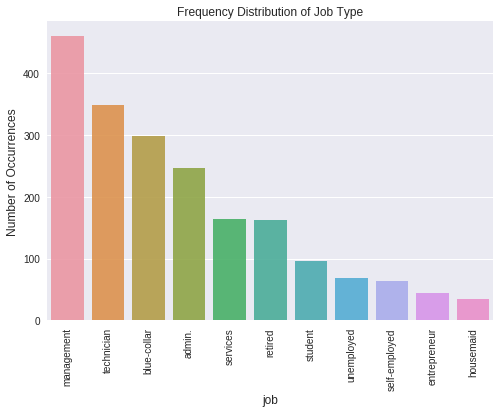

In [0]:

job_count = df['job'].value_counts()
sns.set(style="darkgrid")
sns.barplot(job_count.index, job_count.values, alpha=0.9)
plt.title('Frequency Distribution of Job Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('job', fontsize=12)
plt.xticks(rotation=90)
plt.show()

The above shows the **Management** to be the most common desciptor of job roles.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


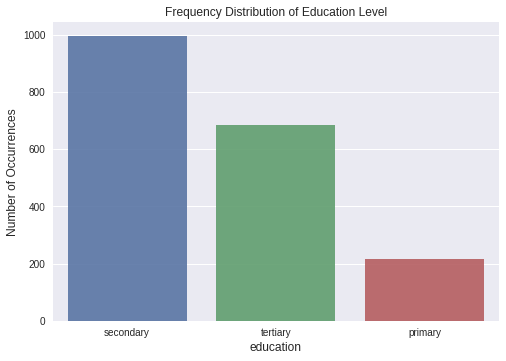

In [0]:
education_count = df['education'].value_counts()
sns.set(style="darkgrid")
sns.barplot(education_count.index, education_count.values, alpha=0.9)
plt.title('Frequency Distribution of Education Level')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('education', fontsize=12)
plt.show()

The above gives a breakdown of the levels of education, with seconday being almost 50% of the level of education achieved by the account holders.

Text(0, 0.5, 'Number of Individuals')

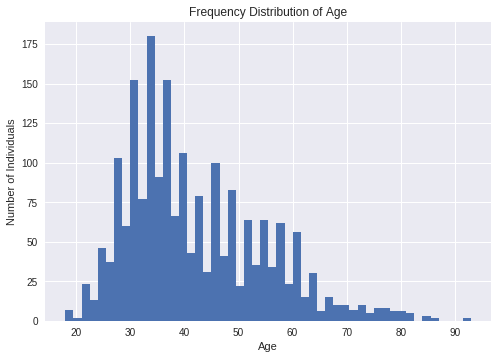

In [0]:
df['age'].hist(bins=50)
plt.title('Frequency Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')

The above shows that the bulk of the individuals within the dataset are aged from 25 to 45 with some outliers, particularly on the upper end of the scale. Wit the data as it is and the upper values being plausible we have no reason to believe that these values are in error thereby there is no reason to exclude them from the dataset.

Text(0, 0.5, 'Number of Individuals')

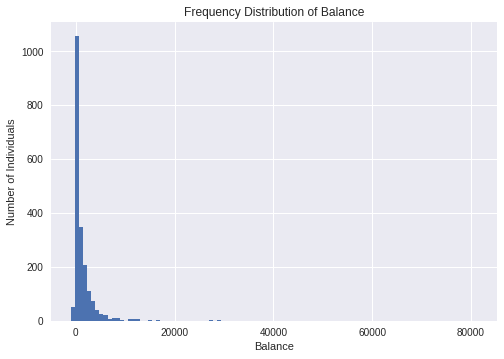

In [0]:
df['balance'].hist(bins=100)
plt.title('Frequency Distribution of Balance')
plt.xlabel('Balance')
plt.ylabel('Number of Individuals')

Looking at the balance attribute it shows that the majority of customers are somewhere around the mean value of 1413 but there is one obvious outlier of ~80,000. This may have to be cleaned/excluded in time.

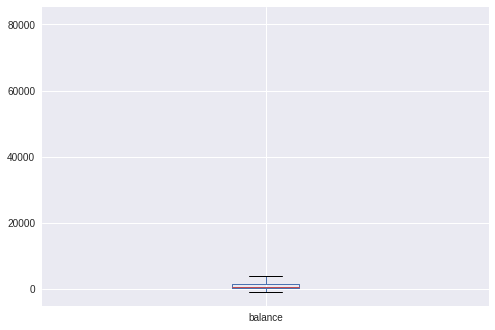

In [0]:
# Next, we look at boxplots to understand the distribution better.

df.boxplot(column='balance')

This reinforces the previous plot above.

Text(0.5, 0.98, '')

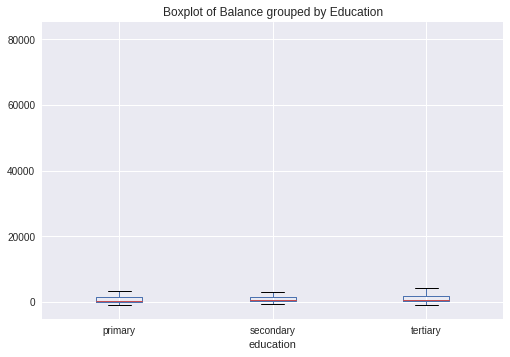

In [0]:
# Boxplots of Balance, grouped by the categorical attribute Education
df.boxplot(column='balance', by='education')
plt.title('Boxplot of Balance grouped by Education')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title

The above box plots give a breakdown of the balance versus education levels. While all 3 levels show a similar mean range, the standard deviation of tertiary level education is muc greater. This would imply a broader spread of balance values amongst those with 3rd level education.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Age')

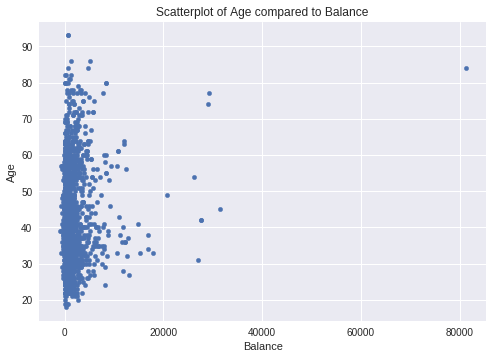

In [0]:
df.plot.scatter(x='balance', y='age')
plt.title('Scatterplot of Age compared to Balance')
plt.xlabel('Balance')
plt.ylabel('Age')

The above scatter plot compares age against balance. Despite the fact that the balance values are clustered around the mean value as mentioned above, when compared to Age it shows that similar balance values are spread right across the age spectrum

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Ratio of Loan to Income')

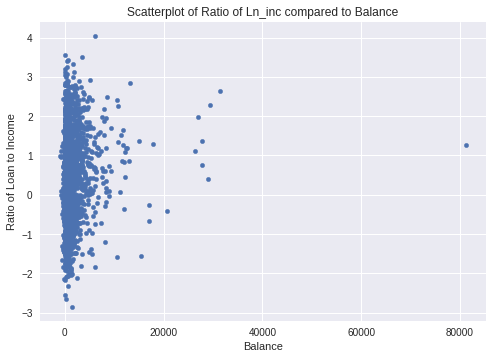

In [0]:
df.plot.scatter(x='balance', y='ratio_ln_inc')
plt.title('Scatterplot of Ratio of Ln_inc compared to Balance')
plt.xlabel('Balance')
plt.ylabel('Ratio of Loan to Income')

The above scatterpolot shows a very similar trend to the previous one, the balance values in the region of the Balance mean are spreadd right acroos the spectrum of Loan to Income Ratios

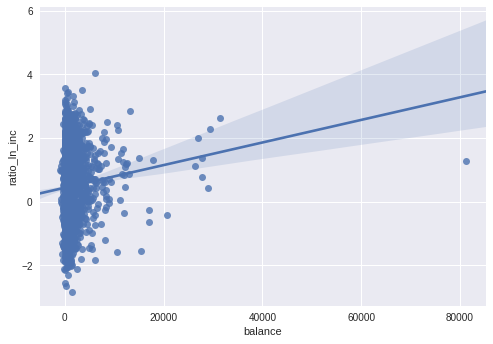

In [0]:
sns.regplot(x='balance', y='ratio_ln_inc', data=df)

Unfortunately the above reg plot doesn't offer any further clarification on the data in terms of identifying a patter between the balance and the ratio of loan to income

In [0]:
frequency_table = df['loan'].value_counts(ascending=True)
print('Frequency Table for Existing Loan:') 
print(frequency_table)

Frequency Table for Existing Loan:
yes     250
no     1750
Name: loan, dtype: int64


This shows that within the Load attribute, the majority of the individuals have no loan. This can imply already stringent criteria in the loan application process.

In [0]:
pivot_table = df.pivot_table(values='housing',
                       index=['loan'],
                       aggfunc=lambda x: x.map({'yes':1, 'no':0}).mean()) 

In [0]:
# Print pivot table
print(pivot_table)

       housing
loan          
no    0.453143
yes   0.680000


THe above shows that housing can be a big indicator of having a loan with there being a 68% probability of someone with housing having a loan.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

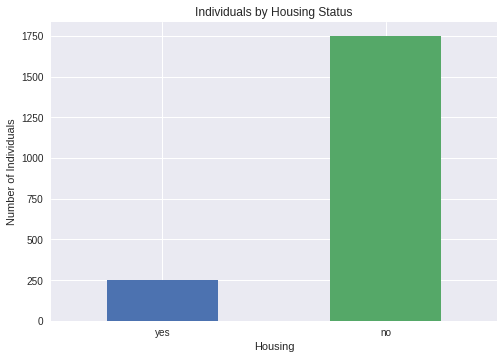

In [0]:
# Plot the frequency table for Housing Status
frequency_table.plot(kind='bar')
plt.xlabel('Housing')
plt.ylabel('Number of Individuals')
plt.title('Individuals by Housing Status')
plt.xticks(rotation='horizontal')

Eventhough the breakdown of numbers of those with housing and those not having housing is very similar to the breakdown of those with a loan and without one, the correlation isn't direct. As will be shown in the following plot.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

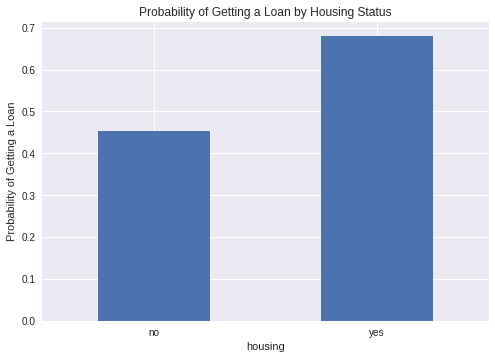

In [0]:
# Plot pivot table
pivot_table.plot(kind='bar')
plt.xlabel('housing')
plt.ylabel('Probability of Getting a Loan')
plt.title('Probability of Getting a Loan by Housing Status')
plt.legend().set_visible(False)
plt.xticks(rotation='horizontal')

Text(0, 0.5, 'Number of Individuals')

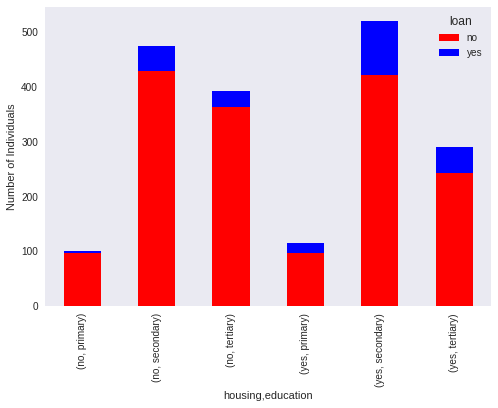

In [0]:
stacked_chart_education = pd.crosstab([df['housing'], df['education']], df['loan'])
stacked_chart_education.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)
plt.ylabel('Number of Individuals')

The above shows that if you have housing and a secondary education you have a greater probability of getting a loan relative to the other possible scenarios combing the housing and education attributes.

Text(0, 0.5, 'Ratio_ln_in')

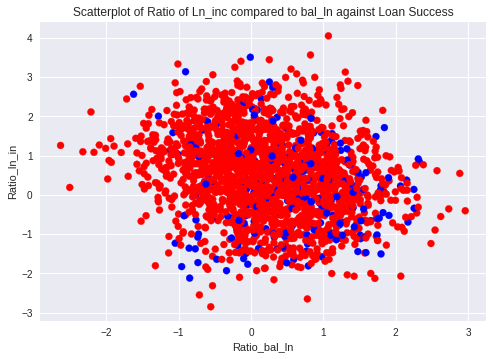

In [0]:
colors = {'yes': 'b', 'no': 'r'}

plt.scatter(df['ratio_bal_ln'], df['ratio_ln_inc'], color=[colors[r] for r in df['loan']])
plt.title('Scatterplot of Ratio of Ln_inc compared to bal_ln against Loan Success')
plt.xlabel('Ratio_bal_ln')
plt.ylabel('Ratio_ln_in')

I have chosen the Loan to Income (Ln_inc) and Balance to Loan (bal_ln) attributes to classify the Loan dependent variable. The plot above shows the comparison. As it stands they are unfortunately not linearly seperable. Although other attributes are plotted above I don't think they give an good indication in order to determine the desired dependent variable, Loan. While the two attributes chosen above are well clustered and I believe I can work with these. The Loan dependent variable is chosen purely from a practicatlity perspective. I Appreciate that it does not have an even spread of Yes/No within the 2000 samples but I don't believe an even spread of these to be a pre-requisite for a desired classification exercise.

# Task 3


  Consider the two numerical attributes picked in Task 2 and describe (in a markdown cell) how a perceptron can be used to perform 2-class classification. Use the following terms in your description:

In summary, the data provided contains bank account details for 2000 customers. This dataset will be used help the bank to predict whether future applicants should be granted a loan or not based on information provided within the dataset on previous customers. 

Below is my commentary on the various terms requested. It could well be more eloquently put and I may have some misunderstanding in there so please feel free to point them out to me but considering how difficult I am finding Task 4 I'd rather focus my time on that.

The **Input space** will be the training data set including the numerical attributes chosen above. The **Output space ** will be a level of prediction accuracy for the 2 Class Classification attribute (Loan). The **Unknown target function** will be close to or equal to the **Final Hypohtesis** which will be the optimimum set of weights applied to give us the closest proximity of the **In Sample error** rate (the error rate within the training data set) to the **Out of Sample error** (the error rate from the predicticed values for the test data set). The **Data set** is the entire sample of data which will be broken in to a test and training dataset. The **Hypothesis set** will be all the possible weight scenarios that will have been applied during the training process.

Bullet Point Summary Below:

**Input space X**
This is the variable X that contains two numerical categories from the dataset of 2000 Records i.e **[‘ratio_bal_ln’,’ratio_ln_inc’]**

**Output space Y**
This is the predictor variable Y that is a categorical category with the dataset of the 2000 in X **['loan']** 

**Unknown target function f : X -> Y**
Is the ideal formula for predicting whether a individual eligible for a loan or not.

**Data set D**  (historical records of bank) 
This is the 2000 historical records of the bank i.e (X1,y1).....(Xn,Yn)

**Hypothesis set** H 
This is the set of candidate formulas 

**Final Hypothesis g = f** 
The decision is based on the g (hypotheis that the learning algorithm produced not on f where the ideal target function that remains unknown

**In-sample error Ein(g)**
This is error rate within the training sample this is explicitly dependent on the hypothesis we are considering.

**Out-of-sample error Eout(g)**
This measures how well the our training on D has generalised to the data that we have not seen before. It is based on the entire input space X. These points must be fresh and have not been used for training




# Task 4

 Suggestion: try PLA on this dataset before using the bank dataset

In [0]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
y = [yy if yy == 1 else -1 for yy in y] 

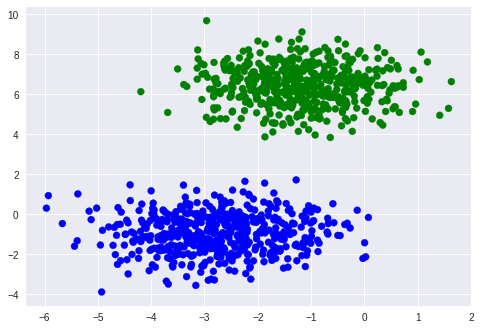

In [18]:
colors = ['green' if yy == 1 else 'blue' for yy in y] 
plt.scatter(X[:,0],X[:,1], color=colors)
plt.show()

In [0]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [0]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [0]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    return [point_on_boundary(weights, x_min), point_on_boundary(weights, x_max)] #Error Corrected

Code of Michel Danjou Used below.

In [0]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        print("\nIteration:", iterations)
        iterations+=1;
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                weights = weights + y*(np.concatenate((bias,x)))
                print("x:{} new weights:{} bias:{} errors:{}".format(x, weights, bias, errors))
                errors+=1;
        if (errors == 0):
            print("Hypothesis found" , iterations ,"iterations")
            break
    return weights, iterations

In [0]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

In [0]:
def exec_pla(X,y):
    w = np.array([0,0,0])
    w[0] = 1
    
    w,n_iterations = pla(X,y,w)
    xs = [X[:,0].min(),X[:,0].max()]
    ys = decision_boundary(w,xs[0],xs[1])
    colors = ['green' if yy == 1 else 'red' for yy in y] 
    plt.scatter(X[:,0],X[:,1], color=colors)
    plt.plot(xs,ys, 'b-')
    plt.title("Iteration: {:.0f} : Bias = {}, weight1 = {:.2f}, weight2 = {:.2f}".format(n_iterations,w[0],w[1],w[2]))
    plt.show()


Iteration: 0
x:[-3.81742011 -1.63729423] new weights:[0.         3.81742011 1.63729423] bias:[1] errors:0
x:[-2.24878063  5.18033326] new weights:[1.         1.56863948 6.81762748] bias:[1] errors:1
x:[-1.46660561  0.53373146] new weights:[0.         3.03524509 6.28389603] bias:[1] errors:2
x:[-0.59054911  0.5260232 ] new weights:[-1.          3.62579419  5.75787283] bias:[1] errors:3
x:[-1.28022409  1.71619285] new weights:[-2.          4.90601828  4.04167997] bias:[1] errors:4

Iteration: 1
Hypothesis found 2 iterations 2


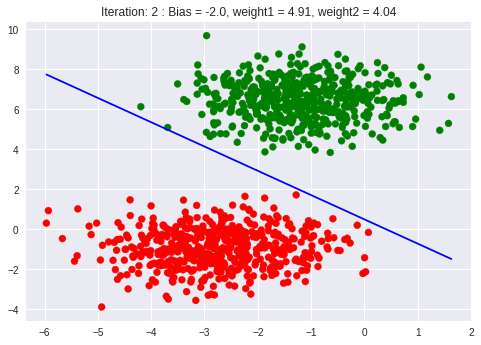

In [37]:
exec_pla(X,y)

The above shows the PLA working with the blobs data with convergence after two iterations. As has become apparant during the last few weeks, this is convenient with the blobs data as the attributes are linearly seperable. Thus PLA works well in this scenario, as has also become obvious is that PLA does not work well alone when the attributes in question (as is the case for those selected and plotted in Task 2) are not linearly seperable.

From reading through the above code and from numerous discussions and documents on PLA there are two obvious issues with applyin PLA with the sample dataset for this etivity:

1. As mentioned in the above, this only works as is for for linearly seperable data as it only stops when zero error has been calculated

2. If zero error has not been detetected and we decide to limit the number of iterations so as not to have PLA running infinitely, there is no guarantee that the iteration at which it stops gives the best weight settings thereby it may not be the ideal (Final) Hypotesis.


We can make improvements on PLA by introducing a pocket algorithim as well as by limiting the number of iterations.

Limiting the number of iterations will prevent PLA from running infinitely, while according to the videos and documentation, the Pocket Algorithm is a funtion that compares the Error Rate of each hypothesis and stores the best performing hypotesis of all the iterations, i.e. putting the best set of weights in 'its pocket'. This deals with issue 2 mentioned above.

----------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
def pocket(training_in, training_out, weights, max_iterations):
    bias = np.array([1])
    iterations=0

    # initialise the pocket algorithm variables
    best_weights = weights
    best_weights_iteration = 0
    best_e = calc_error(training_in, training_out, weights)
    
    while iterations < max_iterations:
        errors = 0;
        iterations+=1;
        print("Iteration:{}/{}".format(iterations, max_iterations))
        
        for x,y in zip(training_in, training_out):           
            if (h(x,weights)!=y):
                
                # pocket best results
                e = calc_error(training_in, training_out, weights)
                if (e < best_e):
                    best_e = e
                    best_weights = weights
                    best_weights_iteration = iterations
                    print("Pocketing weights:{} e:{} found at iterations:{}".format(best_weights, best_e, best_weights_iteration))
                
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;                
            
        if (errors == 0):
            print("Hypothesis found", iterations , "iterations")
            break
            
    return best_weights, best_weights_iteration, best_e, iterations 

# New Section
Running PLA on Bank Data set.

Loan attibute to be converted from yes,no to numeric.

In [0]:
df['loan_code'] = df['loan'].map({'yes': 1, 'no': -1})

DF is to be shuffled to make sure that when the data is split there is an even spread of yes/no (1/-1) values between test and training data sets.

I am aware that I have chosen loan as my binary classification attribute and that this brings issues with it in that the majority of the samples are 'no' in this attribute. I chose this as I think this is a good real world scenario but I am aware that there are risks involved with this when it comes to DL namely:

1. The split between training and test data set when there isn't an even spread of binary classification scenarios can lead to one set not being a fair reflection of the other set which may cause poor performance comparisons

2. The fact that one classification out weights an other considerably can lead to a build that doesn't peform well in a real world scenario.

I see there was a very good discussion on this very subject ont he forum and that there are a number of ways (albeit only one recommended way) of dealing with such situations but considering how much I struggled with this etivity as is I chose not to go down the rabbit hole of trying to incorporate this solution. Maybe it is something we will get a chance to deal with later in the course.

In [0]:
X_shuffled, y_shuffled = shuffle(X, y, random_state=0)


In [48]:
 df[["loan", "loan_code"]].head(5)

,loan,loan_code
0,no,-1
1,yes,1
2,yes,1
3,yes,1
4,no,-1


In [58]:
 df[["loan", "loan_code"]].tail(5)

,loan,loan_code
1995,no,-1
1996,no,-1
1997,no,-1
1998,no,-1
1999,no,-1


initial tail.(5) printout shows all samples to be in the no/-1 category. This is not comforting as it doesn't confirm that the shuffle function worked. The below print out does show a random allocation of yes/no values in the dataset so the shuffle function has been shown to work.

In [50]:
 df[["loan", "loan_code"]].tail(50)

,loan,loan_code
1950,no,-1
1951,no,-1
1952,no,-1
1953,no,-1
1954,no,-1
1955,no,-1
1956,no,-1
1957,no,-1
1958,no,-1
1959,no,-1


In [0]:
# Generate random weights
def generate_weights():
    weights = np.array([np.random.uniform(-1,1) for i in range(3)])
    print("Random weights:", weights)
    return weights

We now need to perform the below:


1.  Initialise the weights
2.  Define how many iterations of the PLA will be executed 
3.  Split the data between a training dataset and a testing dataset



In [52]:
# Initiatialise the weights with random values
weights = generate_weights()

Random weights: [ 0.36423211  0.46678838 -0.1118573 ]


In [0]:
# Number of iterations before exiting the PLA.
max_iterations = 20


In [0]:
# Use 'ratio_bal_ln' and 'ratio_ln_inc' as our inputs
X = df[['ratio_bal_ln', 'ratio_ln_inc']].values

In [0]:
#Use 'loan_code' as the target
y = df["loan_code"].values

In [0]:
#Split the data in to training and test data 80/20 split

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2)


# Apply the Pocket Algorithm on the training set to determine Ein

In [73]:
best_weights, best_weights_iteration, best_e, total_iterations = \
pocket(X_train, y_train, weights, max_iterations)

print("="*80)
print("Best weights                   :", best_weights)
print("Best weights found at iteration:", best_weights_iteration)
print("Best e (Ein)                   :", best_e)

Iteration:1/20
Pocketing weights:[ 1.36423211 -2.23697958  5.91849606] e:0.30125 found at iterations:1
Pocketing weights:[0.36423211 0.27182053 6.8387388 ] e:0.0725 found at iterations:1
Pocketing weights:[-0.63576789  3.08348052  5.88138823] e:0.00625 found at iterations:1
Pocketing weights:[-1.63576789  3.67402962  5.35536503] e:0.00125 found at iterations:1
Iteration:2/20
Iteration:3/20
Hypothesis found 3 iterations
Best weights                   : [-1.63576789  3.67402962  5.35536503]
Best weights found at iteration: 1
Best e (Ein)                   : 0.00125


The Pocket Algorithim found the best weights at iteration 1 but an **Ein** of .125%. This to me seems suspiciously low which may well be due to the imbalanced nature of the yes/no values within the loan attribute. This may prove to cause issues later when applying these weights to the test data. I will proceed noneteless



# Applying the Weights found by the Pocket Algorithm to the testing data to determine Eout

In [74]:
error = calc_error(X_test, y_test, best_weights)
print("Eout:", error)

Eout: 0.0


We can see here that the Eout is showing as zero, ideally this is a good thing as an ultimate objective and also in that it's a close to the E in value of .0125. I say this as ideally, Ein and Eout will be as close to eachother as posisble while also as close to 0 as possible. But again, I believe this to be too good to be true but will proceed nonetheless

** Plot the line separating the two clusters**

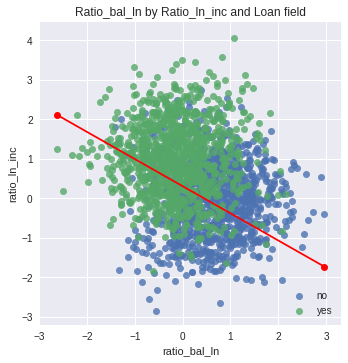

In [75]:
sns.lmplot( x="ratio_bal_ln", y="ratio_ln_inc", data=df, fit_reg=False, hue='subscribed', legend=False)
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Ratio_ln_inc and Loan field")
plt.legend(loc='lower right')

x_min = min(X[:,0])
x_max = max(X[:,0])
y_min, y_max = decision_boundary(best_weights, x_min, x_max)

plt.plot([x_min, x_max], [y_min, y_max], 'ro-')
plt.show()

The decision boundary shown above shows that the data is not linearly seperable and yet the classification error rate is low. This is somewhat contradictory. I'm not comfortable with this scenario nor am I competent enough to dig in to it much deeper. Never the less, I will run a number of esperiments below in order to be able to plot a trend of Ein and Eouts to compare.

In [0]:
# Experiment
def experiment(X_data, y_data):
    best_weights, best_weights_iteration, best_e, total_iterations = \
        pocket(X_data, y_data, generate_weights(), max_iterations)
    return {"error":best_e, "weights":best_weights}

In [0]:
M=20

In [78]:
Eins = []
Eouts = []
for e in range(M):
    print("\nSimulate Bin #:{}/{}".format(e+1,M))
    
    # shuffle and re-split before each experiment
    X_shuffled, y_shuffled = shuffle(X, y, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2)
    
    results = experiment(X_train, y_train)
    print("results.['error']:", results['error'])
    print("results.['weights']:", results['weights'])
    
    Ein = results['error']
    Eout = calc_error(X_test, y_test, results['weights'])

    Eins.append(Ein)
    Eouts.append(Eout)

print("Eins:", Eins)
print("Eouts:", Eouts)


Simulate Bin #:1/20
Random weights: [-0.6823097  -0.37469727  0.82037838]
Iteration:1/20
Pocketing weights:[-1.6823097  -0.56648474 -0.98891259] e:0.126875 found at iterations:1
Pocketing weights:[-1.6823097  -0.07102864  0.35083273] e:0.125 found at iterations:1
Iteration:2/20
Iteration:3/20
Iteration:4/20
Pocketing weights:[-3.6823097  -0.50932059  1.05062015] e:0.124375 found at iterations:4
Iteration:5/20
Iteration:6/20
Iteration:7/20
Iteration:8/20
Iteration:9/20
Iteration:10/20
Iteration:11/20
Iteration:12/20
Iteration:13/20
Iteration:14/20
Iteration:15/20
Iteration:16/20
Iteration:17/20
Iteration:18/20
Iteration:19/20
Iteration:20/20
results.['error']: 0.124375
results.['weights']: [-3.6823097  -0.50932059  1.05062015]

Simulate Bin #:2/20
Random weights: [ 0.55652989 -0.74213693  0.61350021]
Iteration:1/20
Pocketing weights:[-0.44347011 -0.28607364  0.44246522] e:0.40875 found at iterations:1
Pocketing weights:[-1.44347011 -0.22885753 -2.29521205] e:0.21625 found at iterations

** Eins and Eouts distribution**

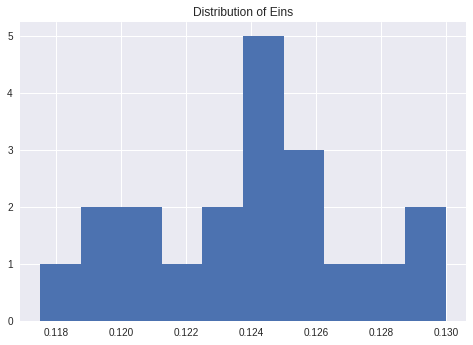

In [79]:
plt.hist(Eins)
plt.title('Distribution of Eins')
plt.show()

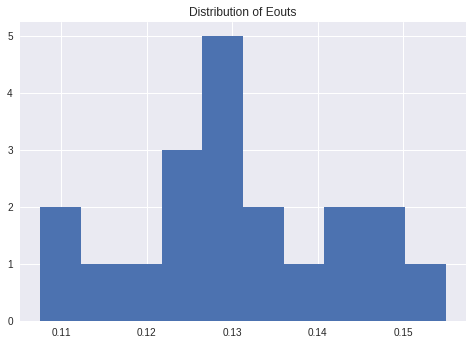

In [80]:
plt.hist(Eouts)
plt.title('Distribution of Eouts')
plt.show()

Eout shows a broader distribution than Ein but that said all of the Ein samples fall within the most prevelant range of Eout values. This indicates a certain level of consistency in the the Pocket Algorithm.

Now to calculate and plot the probability of the difference between Ein and Eout in relation to epsilon and the Hoeffding bound

In [81]:
# Calculate probabily of epsilon
prob_epsilon=[]
epsilons = np.arange(0, 1, 0.01)

for e in epsilons:   
    counter = 0
    for i in range(M):
        if abs(Eins[i] - Eouts[i])>e:
               counter +=1
    prob_epsilon.append(counter/M)           

N = len(X)

print("epsilon proba. dist:", prob_epsilon)
print("M (experiment repeats):", M)
print("N (nb samples):", N)

epsilon proba. dist: [0.9, 0.5, 0.3, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
M (experiment repeats): 20
N (nb samples): 2000


<function matplotlib.pyplot.show>

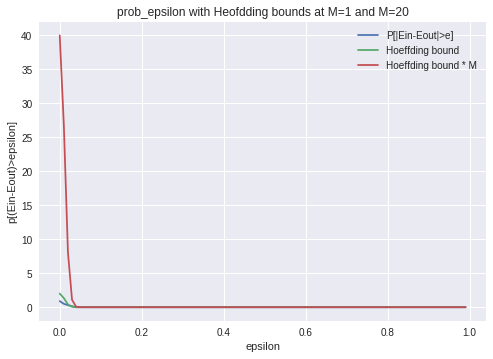

In [83]:
plt.figure()
plt.plot(epsilons, prob_epsilon, label='P[|Ein-Eout|>e]')
plt.plot(epsilons, [2*math.exp(-2*e**2*N) for e in epsilons], label='Hoeffding bound')
plt.plot(epsilons, [2*M*math.exp(-2*e**2*N) for e in epsilons], label="Hoeffding bound * M")
plt.xlabel('epsilon')
plt.ylabel('p[(Ein-Eout)>epsilon]')
plt.title('prob_epsilon with Heofdding bounds at M=1 and M=20')
plt.legend(loc='upper right')
plt.show

A convergance towards 0 can be seen with the larger value of M showing a slight (but relatively large) delay in getting towards 0. One can only imagine the larger the value of M the longer it would take. We can now zoom in on the area where x=0 and y=0.

<function matplotlib.pyplot.show>

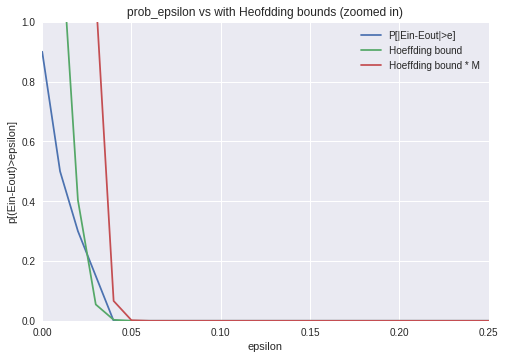

In [85]:
plt.figure()
plt.plot(epsilons, prob_epsilon, label='P[|Ein-Eout|>e]')
plt.plot(epsilons, [2*math.exp(-2*e**2*N) for e in epsilons], label='Hoeffding bound')
plt.plot(epsilons, [2*M*math.exp(-2*e**2*N) for e in epsilons], label="Hoeffding bound * M")

axes = plt.gca()
axes.set_xlim([0,0.25])
axes.set_ylim([0,1])

plt.xlabel('epsilon')
plt.ylabel('p[(Ein-Eout)>epsilon]')
plt.title('prob_epsilon vs with Heofdding bounds (zoomed in)')
plt.legend(loc='upper right')
plt.show